In [138]:
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [139]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [140]:
IMAGE_DIR = "input"

MASK_DIR = "output"
BATCH_SIZE = 4

In [141]:
def convolution_block(input_tensor, num_filters):
    # Apply two convolutional layers with ReLU activation
    x = tf.keras.layers.Conv2D(
        num_filters,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"
    )(input_tensor)
    x = tf.keras.layers.Conv2D(
        num_filters,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"
    )(x)
    return x

def encoder_block(input_tensor, num_filters):
    # Encoder block: Convolution followed by max pooling and dropout
    convolved_features = convolution_block(input_tensor, num_filters)
    pooled_features = tf.keras.layers.MaxPool2D(pool_size=2)(convolved_features)
    pooled_features = tf.keras.layers.Dropout(rate=0.3)(pooled_features)
    return convolved_features, pooled_features

def decoder_block(input_tensor, skip_connections, num_filters):
    # Decoder block: Transposed convolution, concatenation with skip connection, dropout
    x = tf.keras.layers.Conv2DTranspose(
        num_filters,
        kernel_size=3,
        strides=2,
        padding="same"
    )(input_tensor)
    x = tf.keras.layers.concatenate([x, skip_connections])
    x = tf.keras.layers.Dropout(rate=0.3)(x)
    x = convolution_block(x, num_filters)
    return x

def build_unet_model(input_shape=(128, 128, 3), output_channels=1):
    # Define the input tensor
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Constructing the encoder (downsampling path)
    conv1, pool1 = encoder_block(inputs, 32)
    conv2, pool2 = encoder_block(pool1, 64)
    conv3, pool3 = encoder_block(pool2, 128)
    conv4, pool4 = encoder_block(pool3, 256)
    
    # Bottleneck part of the network
    bottleneck_features = convolution_block(pool4, 512)

    # Constructing the decoder (upsampling path)
    up1 = decoder_block(bottleneck_features, conv4, 256)
    up2 = decoder_block(up1, conv3, 128)
    up3 = decoder_block(up2, conv2, 64)
    up4 = decoder_block(up3, conv1, 32)

    # Final output layer with sigmoid activation
    final_output = tf.keras.layers.Conv2D(
        output_channels,
        kernel_size=1,
        padding="same",
        activation="sigmoid"
    )(up4)

    # Assembling the full model
    unet_model = tf.keras.Model(inputs=inputs, outputs=final_output, name="Enhanced_U-Net")
    return unet_model



In [142]:

def load_images(image_path, mask_path):
    images, masks, fnames = [], [], []
    for image_name in sorted(os.listdir(image_path)):
        image = cv2.imread(os.path.join(image_path, image_name))
        image = cv2.resize(image, (256, 256))
        mask_name = image_name.replace(".png", ".tif")
        mask = cv2.imread(os.path.join(mask_path, mask_name))
        mask = cv2.resize(mask, (256, 256))
        images.append(image)
        masks.append(mask)
        fnames.append(image_name)
    return images, masks, fnames

In [144]:
def augmentation_fn(image, mask, training=True):
    img_aug = image.copy()
    mask_aug = mask.copy()

    if training:
        # randomly change the brightness
        img_aug = tf.image.random_brightness(img_aug, 0.1)
        # randomly change the hue
        img_aug = tf.image.random_hue(img_aug, 0.1)

        # randomly flip the image horizontally
        if np.random.rand() > 0.5:
            img_aug = tf.image.flip_left_right(img_aug)
            mask_aug = tf.image.flip_left_right(mask_aug)

        # randomly flip the image vertically
        if np.random.rand() > 0.5:
            img_aug = tf.image.flip_up_down(img_aug)
            mask_aug = tf.image.flip_up_down(mask_aug)


    # Normalization factor for scaling images
    normalization_factor = 122.5

    # Resize and normalize the image to the range [-1, 1]
    image_resized_normalized = (tf.image.resize(image, (128, 128)) / normalization_factor) - 1.0

    # Resize the mask and apply a threshold to create a binary mask
    mask_resized = tf.image.resize(mask, (128, 128))
    mask_resized_binary = tf.cast(mask_resized > normalization_factor, tf.float32)

    # Ensure mask has the correct shape by adding a channel dimension
    mask_final = mask_resized_binary[:, :, :1]

    return image_resized_normalized, mask_final



In [145]:
# Split train and test
images_arr, masks_arr, fnames = load_images(IMAGE_DIR, MASK_DIR)
mask = list(range(len(images_arr)))
np.random.seed(0)
np.random.shuffle(mask)
n_train = int(0.8*len(mask))
X_train = [images_arr[i] for i in mask[:n_train]]
Y_train = [masks_arr[i] for i in mask[:n_train]]
name_train = [fnames[i] for i in mask[:n_train]]

X_test = [images_arr[i] for i in mask[n_train:]]
Y_test = [masks_arr[i] for i in mask[n_train:]]
name_test = [fnames[i] for i in mask[n_train:]]

def data_generator(imgs, arrs, batch_size=BATCH_SIZE, training=True):
    n_data = len(imgs)

    i = 0
    while True:
        if i + batch_size > n_data:
            i = 0
            mask = np.arange(n_data)
            np.random.shuffle(mask)

            imgs = [imgs[j] for j in mask]
            arrs = [arrs[j] for j in mask]
        
        mini_X = imgs[i: i + batch_size] 
        mini_Y = arrs[i: i + batch_size]

        
        processed_data = [augmentation_fn(x, y, training) for x, y in zip(mini_X, mini_Y)]
        mini_X = [item[0] for item in processed_data]
        mini_Y = [item[1] for item in processed_data]


        mini_X = tf.concat([tf.expand_dims(_, axis=0) for _ in mini_X], axis=0)
        mini_Y = tf.concat([tf.expand_dims(_, axis=0) for _ in mini_Y], axis=0)

        i += batch_size
        yield mini_X, mini_Y



In [146]:
model = build_unet_model()

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=log_dice_loss,
    metrics=[dice_coef, iou]
)

train_generator = data_generator(X_train, Y_train, training=True)
validation_generator = data_generator(X_test, Y_test, training=False)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=300,
    validation_data=validation_generator,
    steps_per_epoch=len(X_train)//BATCH_SIZE,
    validation_steps=len(X_test)//BATCH_SIZE,
    callbacks=[early_stopping]
)
model.save("unet.h5")


Model: "Enhanced_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_204 (Conv2D)            (None, 128, 128, 32  896         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_205 (Conv2D)            (None, 128, 128, 32  9248        ['conv2d_204[0][0]']             
                                )                                                    

In [147]:
best_epoch = np.argmin(history.history["val_loss"])
print("Best Validation Loss: ", history.history["val_loss"][best_epoch])
print("Best Dice Coffecient (F1): ", history.history["val_dice_coef"][best_epoch])
print("Best IoU (Jaccard): ", history.history["val_iou"][best_epoch])


Best Validation Loss:  0.06837751716375351
Best Dice Coffecient (F1):  0.9340835809707642
Best IoU (Jaccard):  0.8773374557495117


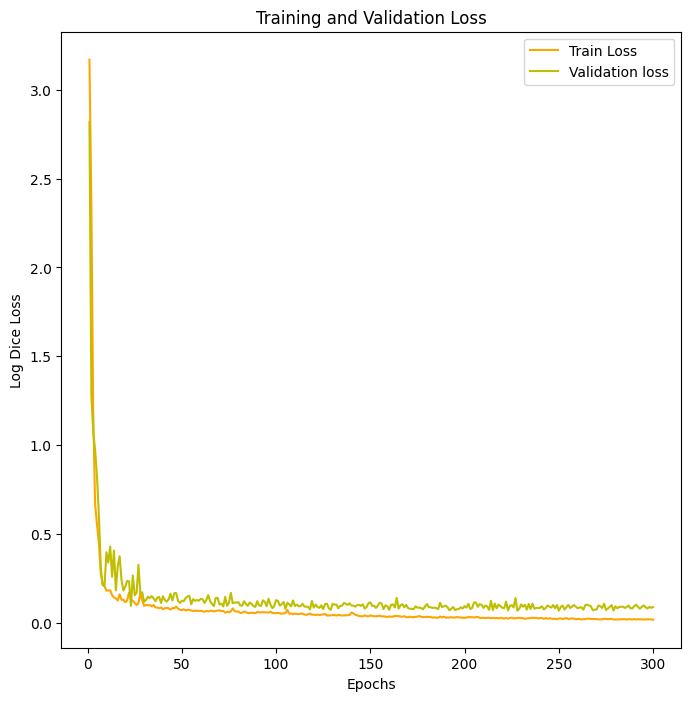

In [148]:
t_loss = history.history['loss']
val_loss = history.history['val_loss']
acc=history.history['dice_coef']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(8, 8))
plt.plot(epochs, t_loss, 'orange', label='Train Loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Dice Loss')
# plt.grid()
plt.legend()

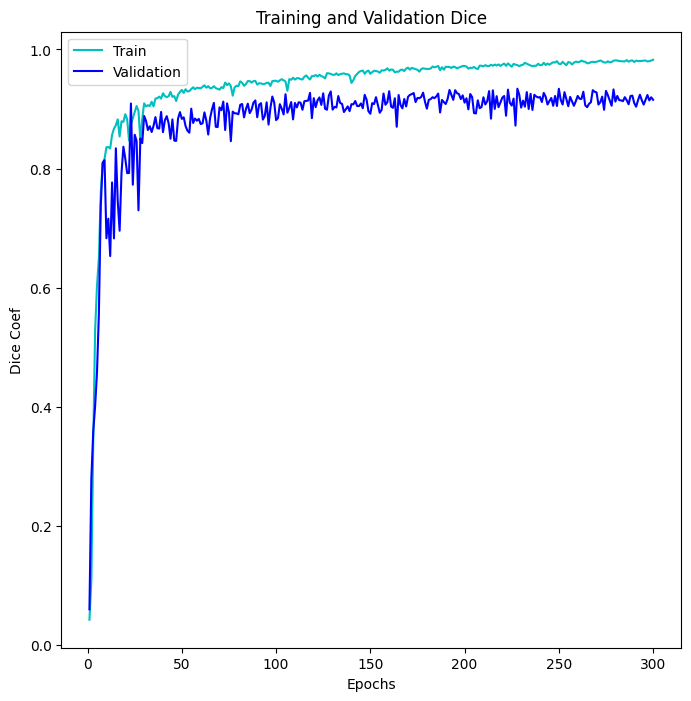

In [149]:

loss = history.history['loss']
acc=history.history['dice_coef']
val_acc=history.history['val_dice_coef']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(8, 8))
plt.plot(epochs, acc, 'c', label='Train')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Training and Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
# plt.grid()
plt.legend()

In [150]:
from skimage.morphology import dilation
from skimage.feature import canny
from skimage import color

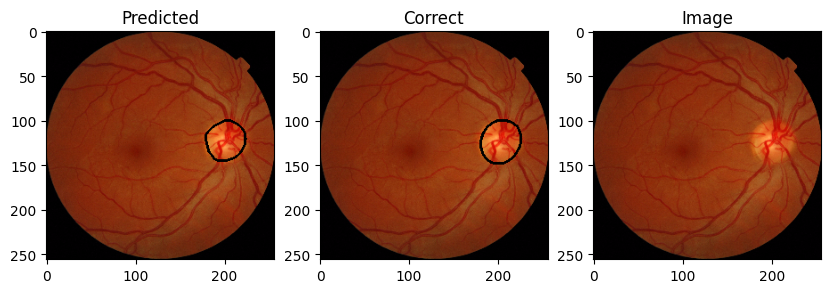

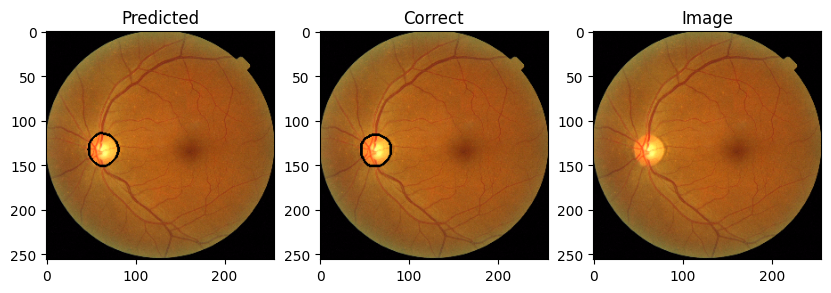

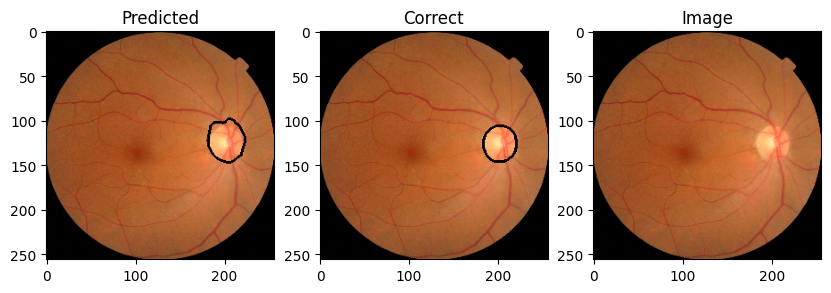

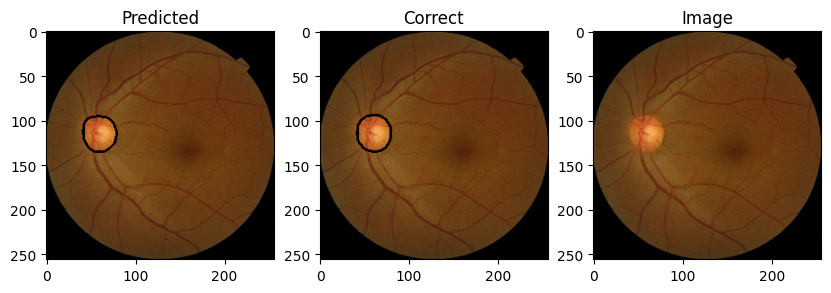

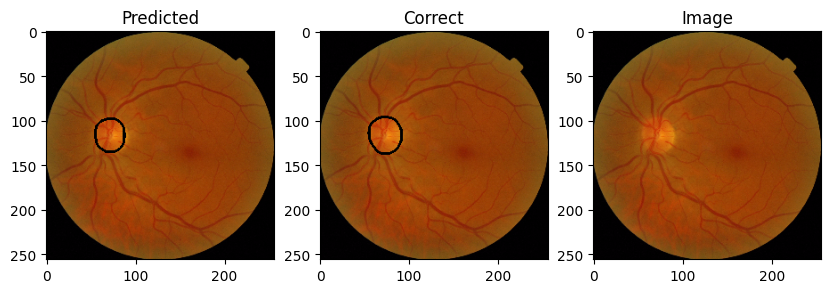

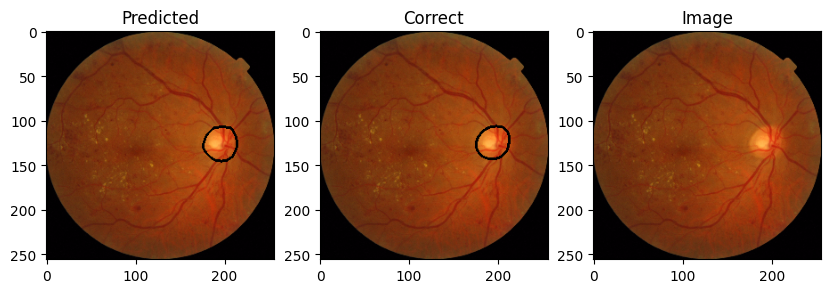

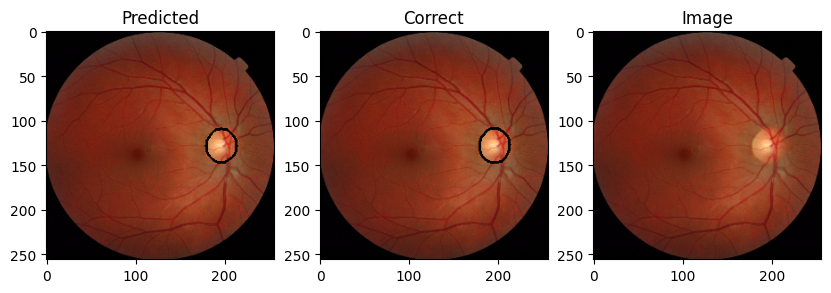

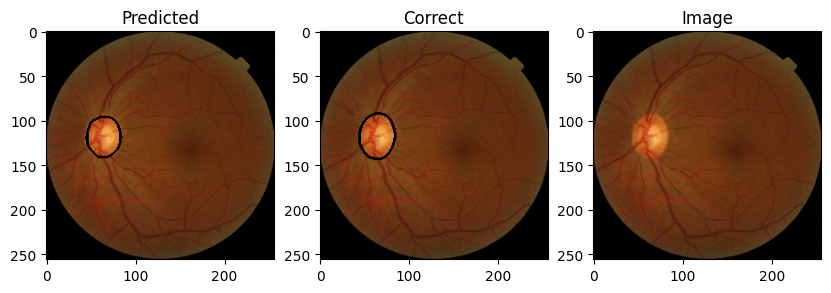

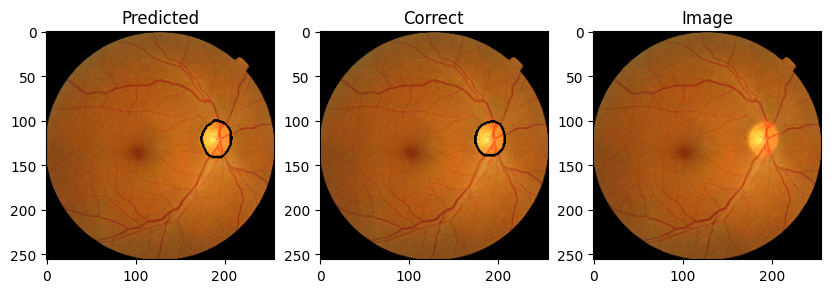

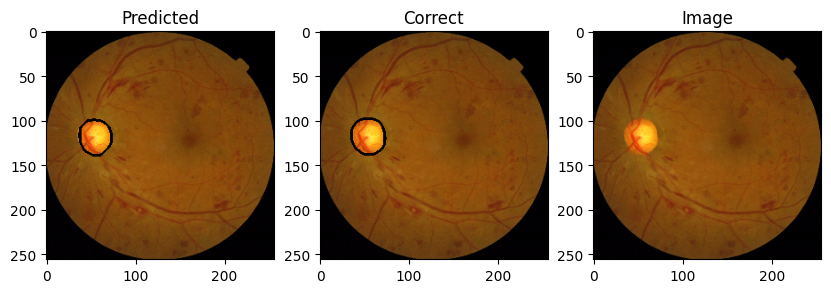

In [151]:
for image , mask, file_name in zip(X_test[: 10], Y_test[:10], name_test[:10]):

    x_test = image.copy()
    x_test = tf.image.resize(x_test, (128, 128))/122.5 - 1.0

    mask = (mask[:, :, 0] > 100) + 0.0
    

    pred = (model.predict(tf.expand_dims(x_test, axis=0), verbose=0)[0] > 0.5).astype(float)
    pred = cv2.resize(pred, (256, 256))

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Predicted')
    edgesp = canny(pred)
    edgesp = 1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow((image*edgesp).astype(int)[:, :, ::-1])


    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('Correct')
    edgesc = canny(mask)
    edgesc = 1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow((image*edgesc).astype(int)[:, :, ::-1])

    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('Image')
    ax.imshow(image[:, :, ::-1])

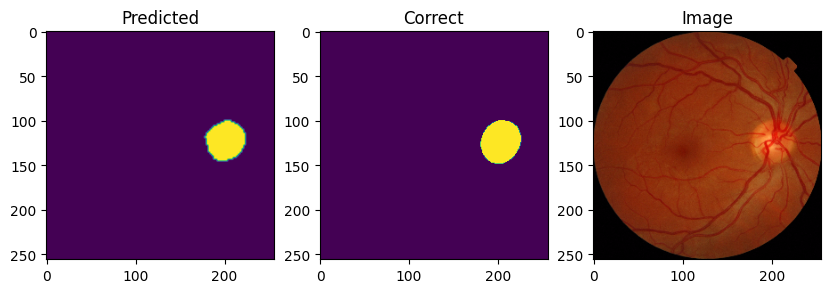

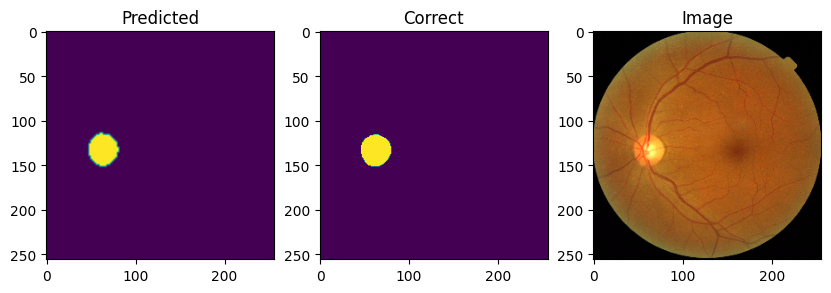

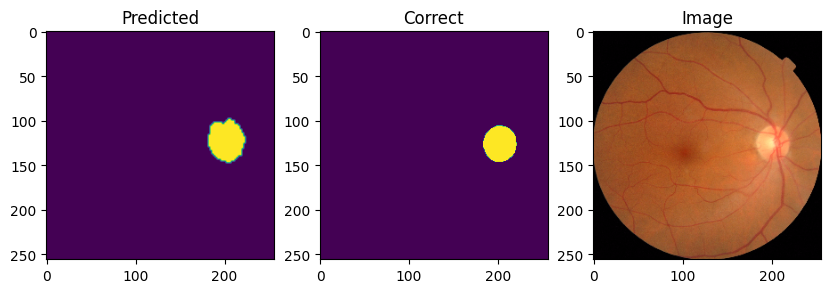

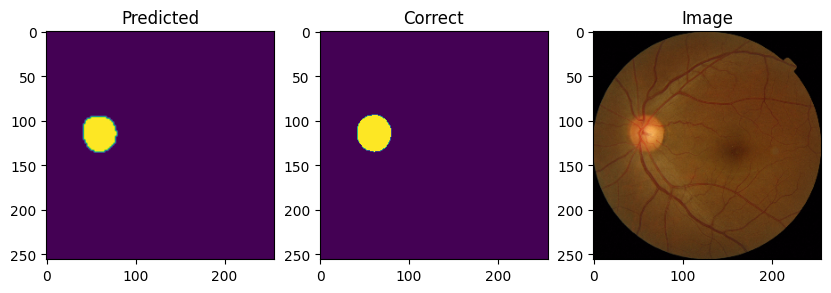

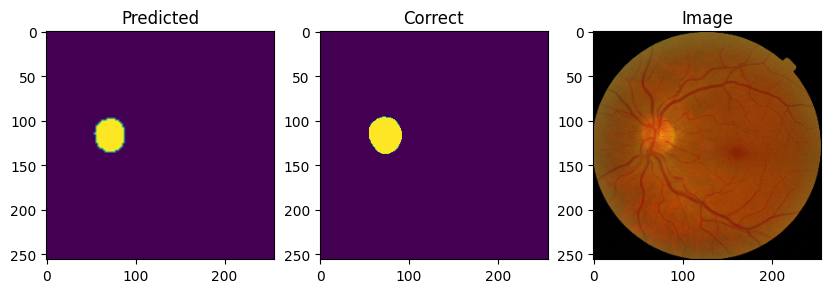

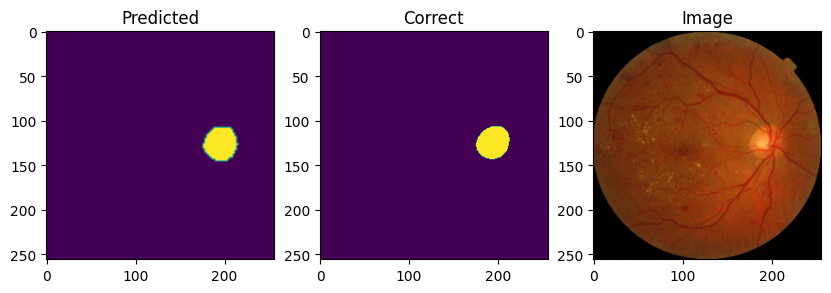

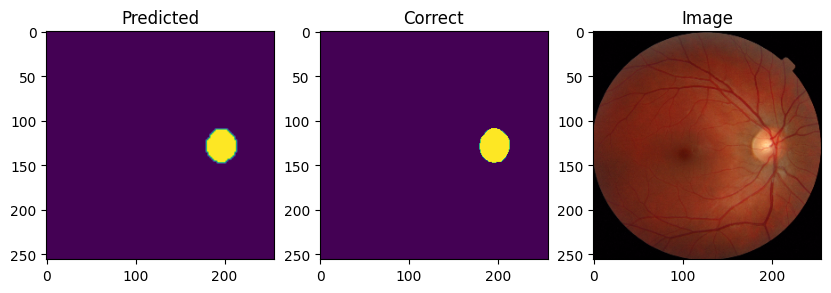

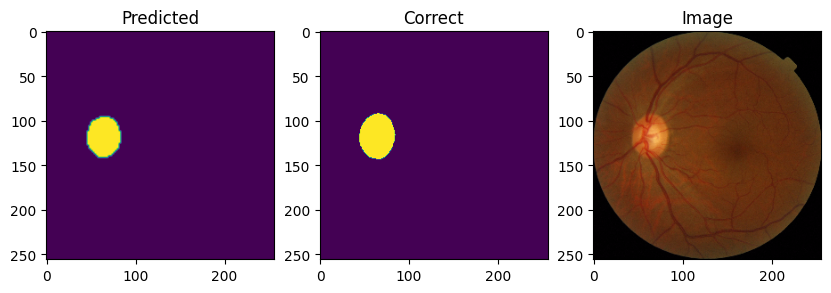

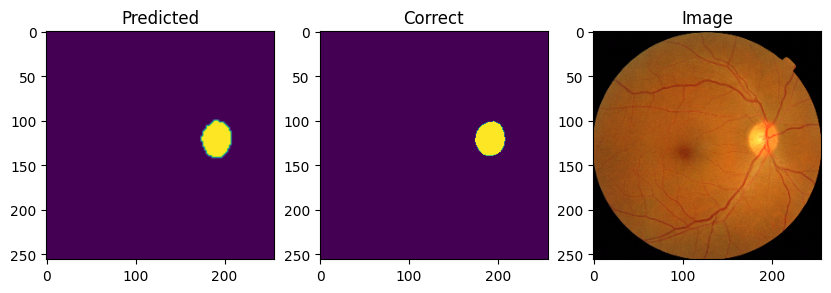

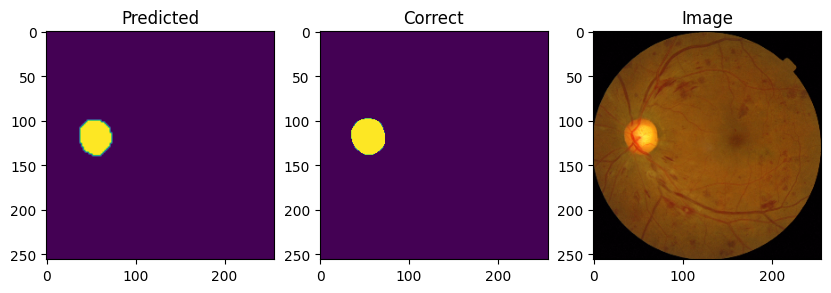

In [152]:
for image , mask, file_name in zip(X_test[: 10], Y_test[:10], name_test[:10]):

    x_test = image.copy()
    x_test = tf.image.resize(x_test, (128, 128))/122.5 - 1.0

    mask = (mask[:, :, 0] > 100) + 0.0
    

    pred = (model.predict(tf.expand_dims(x_test, axis=0), verbose=0)[0] > 0.5).astype(float)
    pred = cv2.resize(pred, (256, 256))

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Predicted')
#     edgesp = canny(pred)
#     edgesp = 1.0-dilation(edgesp)
#     edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(pred)


    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('Correct')
#     edgesc = canny(mask)
#     edgesc = 1.0-dilation(edgesc)
#     edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(mask)

    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('Image')
    ax.imshow(image[:, :, ::-1])